In [1]:
!pip install transformers datasets accelerate scikit-learn -q

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Đang sử dụng thiết bị: {device}")
if device.type == 'cpu':
    print(" CẢNH BÁO: Bạn chưa bật GPU. Hãy vào Runtime -> Change runtime type -> T4 GPU")

Mounted at /content/drive
 Đang sử dụng thiết bị: cuda


In [2]:
FILE_PATH = "/content/drive/My Drive/NLP Project/Data/vnexpress_processed_vncorenlp_for_phobert.csv"

print(" Đang đọc dữ liệu...")
df = pd.read_csv(FILE_PATH)

# Chuyển đổi kiểu dữ liệu cho chắc chắn
df['content_processed'] = df['content_processed'].astype(str)
df['label_id'] = df['label_id'].astype(int)

# Chia tập Train (80%) - Validation (10%) - Test (10%)
# Stratify=y để đảm bảo tỉ lệ các nhãn đều nhau trong các tập
X_train, X_temp, y_train, y_temp = train_test_split(df['content_processed'], df['label_id'],
                                                    test_size=0.2, random_state=42, stratify=df['label_id'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5, random_state=42, stratify=y_temp)

print(f"📊 Kích thước tập dữ liệu:")
print(f"   - Train: {len(X_train)} bài")
print(f"   - Val:   {len(X_val)} bài")
print(f"   - Test:  {len(X_test)} bài")

 Đang đọc dữ liệu...
📊 Kích thước tập dữ liệu:
   - Train: 10984 bài
   - Val:   1373 bài
   - Test:  1373 bài


In [3]:
# Tải về bộ nhớ Colab trước (Tốc độ bàn thờ)
!git lfs install
!git clone https://huggingface.co/vinai/phobert-base /content/phobert_temp

# Sau đó copy vào Drive (Lưu trữ)
import shutil
import os

drive_path = "/content/drive/My Drive/NLP Project/PhoBERT_base_cached"
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

print("Đang copy vào Drive...")
# Copy từng file để tránh lỗi
for filename in os.listdir("/content/phobert_temp"):
    if os.path.isfile(os.path.join("/content/phobert_temp", filename)):
        shutil.copy(os.path.join("/content/phobert_temp", filename), drive_path)

print(f" Xong! Model đã nằm tại: {drive_path}")

Git LFS initialized.
Cloning into '/content/phobert_temp'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56 (from 1)
Unpacking objects: 100% (59/59), 2.45 MiB | 6.36 MiB/s, done.
Filtering content: 100% (3/3), 1.69 GiB | 45.69 MiB/s, done.
Đang copy vào Drive...
 Xong! Model đã nằm tại: /content/drive/My Drive/NLP Project/PhoBERT_base_cached


In [3]:
MODEL_NAME = "/content/drive/My Drive/NLP Project/PhoBERT_base_cached"
print(f" Đang tải Tokenizer từ {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# Tạo Dataset object của HuggingFace
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
val_dataset = Dataset.from_dict({"text": X_val, "label": y_val})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

# Map tokenizer vào dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

 Đang tải Tokenizer từ /content/drive/My Drive/NLP Project/PhoBERT_base_cached...


Map:   0%|          | 0/10984 [00:00<?, ? examples/s]

Map:   0%|          | 0/1373 [00:00<?, ? examples/s]

Map:   0%|          | 0/1373 [00:00<?, ? examples/s]

In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [5]:
num_labels = len(df['label_id'].unique())

print(" Đang tải mô hình PhoBERT Pre-trained...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)

# Hàm tính điểm đánh giá
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Tham số huấn luyện (Hyperparameters)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",           # <--- SỬA DÒNG NÀY (thay evaluation_strategy bằng eval_strategy)
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir='./logs',
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

print(" BẮT ĐẦU HUẤN LUYỆN...")
trainer.train()

 Đang tải mô hình PhoBERT Pre-trained...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/NLP Project/PhoBERT_base_cached and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


 BẮT ĐẦU HUẤN LUYỆN...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.785400,0.306519,0.908958,0.909052,0.911576,0.908958
2,0.268700,0.311251,0.913328,0.911566,0.914888,0.913328
3,0.116300,0.250827,0.936635,0.936233,0.936478,0.936635
4,0.075300,0.274656,0.938820,0.937985,0.938790,0.938820


TrainOutput(global_step=2748, training_loss=0.26569417262181444, metrics={'train_runtime': 2076.4293, 'train_samples_per_second': 21.159, 'train_steps_per_second': 1.323, 'total_flos': 5780438836150272.0, 'train_loss': 0.26569417262181444, 'epoch': 4.0})


 Đang đánh giá trên tập Test...



 KẾT QUẢ CUỐI CÙNG:
{'test_loss': 0.24442486464977264, 'test_accuracy': 0.9395484340859432, 'test_f1': 0.9395029536497211, 'test_precision': 0.9397083033088596, 'test_recall': 0.9395484340859432, 'test_runtime': 18.2977, 'test_samples_per_second': 75.037, 'test_steps_per_second': 2.35}


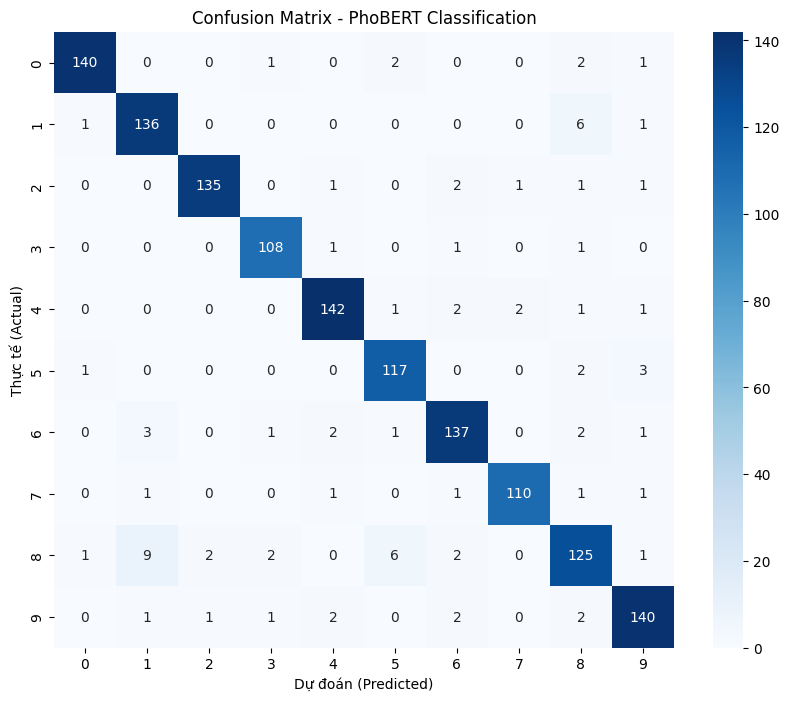

In [6]:
print("\n Đang đánh giá trên tập Test...")
test_results = trainer.predict(tokenized_test)

print("\n KẾT QUẢ CUỐI CÙNG:")
print(test_results.metrics)

# Vẽ Confusion Matrix
y_preds = np.argmax(test_results.predictions, axis=1)
cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix - PhoBERT Classification')
plt.show()

In [7]:
SAVE_PATH = "/content/drive/My Drive/NLP Project/Model_PhoBERT"
trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)
print(f"\n Đã lưu Model thành công tại: {SAVE_PATH}")
print("Bạn có thể dùng model này để chạy Demo.")


 Đã lưu Model thành công tại: /content/drive/My Drive/NLP Project/Model_PhoBERT
Bạn có thể dùng model này để chạy Demo.
